In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models # models has the pre trained model like alex net

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [4]:
!ls ants_and_bees/train/ants

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

In [5]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.RandomAffine(0, shear=10, scale = (0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.9, contrast=0.9, saturation=0.9),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))
                                      ])

transform_val = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
                               ])
training_dataset = datasets.ImageFolder('ants_and_bees/train', transform = transform_train)
val_dataset = datasets.ImageFolder('ants_and_bees/val', transform = transform_val)
val_dataset

Dataset ImageFolder
    Number of datapoints: 153
    Root location: ants_and_bees/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [6]:
def img_convert(tensor):
    im = tensor.cpu().clone().detach().numpy()
    im = im.transpose(1,2,0) 
    #denormalization
    im = im * np.array((0.5,)) + np.array((0.5,))
    im = im.clip(0,1)
    
    return im

In [7]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size = 20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size = 20, shuffle=False) #no training in this dataset, so no need to shuffle

In [8]:
print(len(training_loader.dataset))
print(len(val_dataset))
print(len(training_loader)) 
print(len(val_loader))

244
153
13
8


In [9]:
label_classes = ['ants','bees']

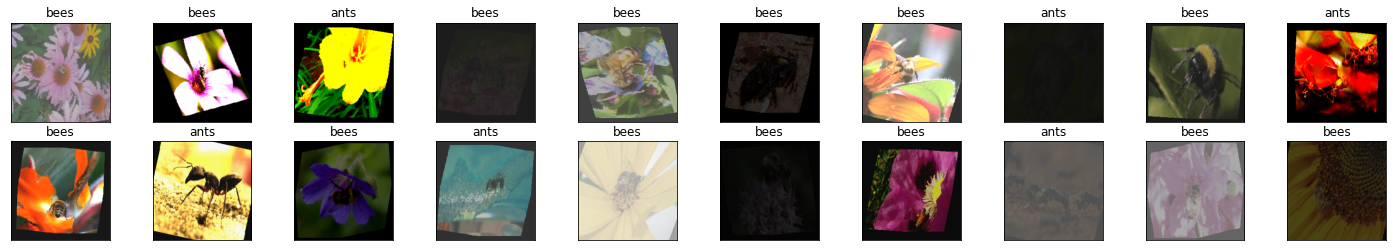

In [10]:
im_iter = iter(training_loader)
imgs, labels = im_iter.next()
fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(img_convert(imgs[i])))
    ax.set_title(label_classes[labels[i].item()])

In [11]:
# model = models.alexnet(pretrained=True)
model = models.vgg16(pretrained=True)

In [12]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
for param in model.features.parameters():
  param.requires_grad = False 
  # Freeze the update of the feature extraction parameters so convolution layer is unaffected by training
  # Parameters in the full connected layer will change for our specific dataset

In [14]:
#need to modify the model to adjust for only 2 output, not 1000 in the last layer

output_size = len(label_classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, output_size)
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003) #smaller learning rate will make the plot of loss function more smooth, as it will avoid overshooting

In [16]:
epochs = 5
losses = []
accuracies = []

val_losses = []
val_accuracies = []

In [17]:
for i in range(epochs):
    print("epoch: ", i+1)
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    val_epoch_loss = 0.0
    val_epoch_acc = 0.0
    
    for images, labels in training_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        loss = loss_func(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, max_idx = torch.max(outputs, 1) # 1 here indicates dim = 1, which is calculating max in horizontal direction, dim = 0 is vertical, dim = 2 is in depth direction.
        epoch_loss += loss.item()
        epoch_acc += torch.sum(max_idx == labels.data).item() # since batch size is 100, no need to divide by size then multiply by 100 to get % accuracy.

    
    tot_loss = epoch_loss/len(training_loader.dataset)
    tot_acc = epoch_acc/len(training_loader.dataset)
    losses.append(tot_loss)
    accuracies.append(tot_acc)
    print("training loss: {:.4f}, accuracy: {:.4f}".format(tot_loss, tot_acc))
    
    #validation phase
    
    with torch.no_grad(): #to save memory, set all grad flags to False
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model.forward(val_images)
            val_loss = loss_func(val_outputs, val_labels)

            _, max_idx = torch.max(val_outputs, 1)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += torch.sum(max_idx == val_labels.data)
     
    val_tot_loss = val_epoch_loss/len(val_loader.dataset)
    val_tot_acc = val_epoch_acc/len(val_loader.dataset)
    val_losses.append(val_tot_loss)
    val_accuracies.append(val_tot_acc)
    print("val loss: {:.4f}, val accuracy: {:.4f}".format(val_tot_loss, val_tot_acc))

epoch:  1
training loss: 0.0357, accuracy: 0.5615
val loss: 0.0269, val accuracy: 0.7908
epoch:  2
training loss: 0.0278, accuracy: 0.7459
val loss: 0.0190, val accuracy: 0.8497
epoch:  3
training loss: 0.0228, accuracy: 0.8238
val loss: 0.0153, val accuracy: 0.9020
epoch:  4
training loss: 0.0181, accuracy: 0.8689
val loss: 0.0121, val accuracy: 0.9281
epoch:  5
training loss: 0.0136, accuracy: 0.9180
val loss: 0.0134, val accuracy: 0.9216


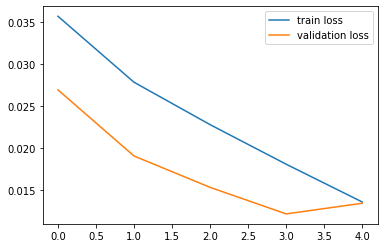

In [18]:
plt.plot(losses, label = 'train loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()

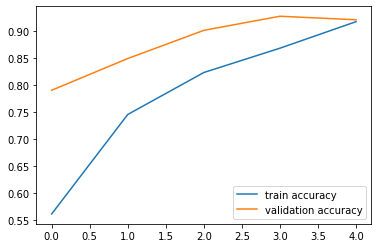

In [19]:
plt.plot(accuracies, label = 'train accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()

<Response [200]>


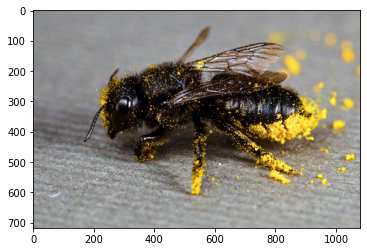

In [20]:
import requests
import PIL
from PIL import Image

# url = 'https://cdn.theatlantic.com/thumbor/ZdCiGfbBHEvCBIT_7vCmGXnIJnI=/0x192:2048x1344/1600x900/media/img/mt/2017/11/29867355174_7c3c99f18c_k/original.jpg'
url = 'https://scitechdaily.com/images/Leafcutter-Bee.jpg'

response = requests.get(url, stream=True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)


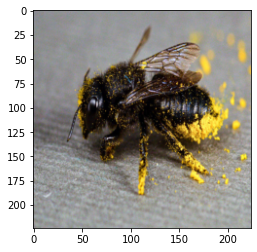

In [21]:
#need to transform image to 32 by 32

img = transform_val(img)
plt.imshow(np.squeeze(img_convert(img))) #now is is like the images we trained

In [22]:
img = img.to(device).unsqueeze(0) # unsqueeze to add additional dimension
outputs = model.forward(img)
_, max_idx = torch.max(outputs, 1)
print(label_classes[max_idx.item()])

bees


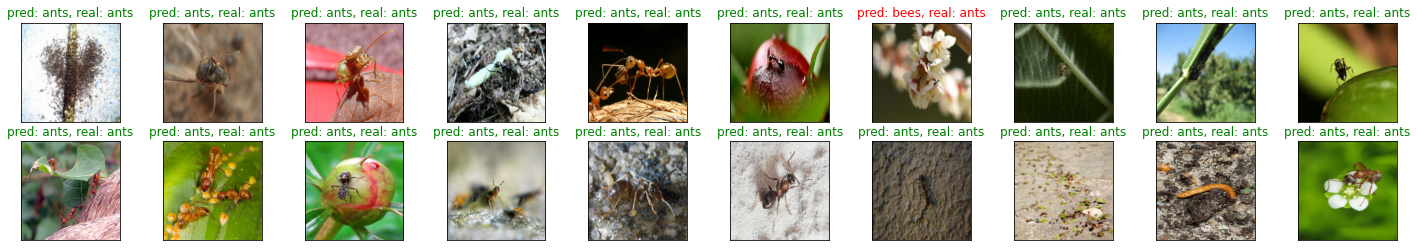

In [23]:
im_iter = iter(val_loader)
images, labels = im_iter.next() # just take one batch and visualize some of these images
images = images.to(device)
labels = labels.to(device)

outputs = model.forward(images)
_, max_idx = torch.max(outputs, 1)


fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(img_convert(images[i])))
    ax.set_title("pred: {}, real: {}".format(label_classes[max_idx[i].item()], label_classes[labels[i].item()]), color = ("green" if max_idx[i] == labels[i] else "red"))